# Modelling Differential Cross Sections (DCS)

### Writing C++ extensions

```cpp
//cpp_intro.cc file

#include <torch/extension.h>

torch::Tensor get_rotations(const torch::Tensor &thetas) {
    const auto f = thetas.flatten();
    const auto n = f.numel();
    const auto c = torch::cos(f);
    const auto s = torch::sin(f);
    return torch::stack({c, -s, s, c}).t().view({n, 2, 2});
}

PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
    m.def("get_rotations", &get_rotations, py::call_guard<py::gil_scoped_release>(),
          "Generate 2D rotations given angles thetas");
}
```

More info:
* [PyTorch C++ tutorial](https://pytorch.org/tutorials/advanced/cpp_extension.html)
* [Pybind11 docs](https://pybind11.readthedocs.io/en/stable/basics.html)

In [21]:
import torch
from torch.utils.cpp_extension import load
import math
from numba import njit, double, int32
import matplotlib.pyplot as plt

If you are on Google Colab execute:
```
!pip install Ninja
!add-apt-repository ppa:ubuntu-toolchain-r/test -y
!apt update
!apt upgrade -y
!apt install gcc-9 g++-9
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-9 100 --slave /usr/bin/g++ g++ /usr/bin/g++-9
```

If you are on Datalore:
```
!pip install Ninja
!sudo apt-get update && sudo apt-get install cuda-nvcc-11-2 -y

```

Check the installation:

In [5]:
!gcc --version
!g++ --version
!nvcc --version

gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

g++ (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [6]:
!mkdir -p build

In [7]:
cpp_intro = load(name='cpp_intro',
             build_directory='./build',
             sources=['cpp_intro.cc'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             verbose=False)

In [8]:
N = 3
PI = 2. * torch.acos(torch.tensor(0.))
thetas = 0.05 * PI * (torch.rand(N) - 0.5) # example of angles in radians
rots = cpp_intro.get_rotations(thetas)
rots

tensor([[[ 9.9774e-01,  6.7158e-02],
         [-6.7158e-02,  9.9774e-01]],

        [[ 1.0000e+00,  2.7296e-04],
         [-2.7296e-04,  1.0000e+00]],

        [[ 9.9947e-01,  3.2567e-02],
         [-3.2567e-02,  9.9947e-01]]])

In [9]:
(rots.matmul(rots.transpose(-1,-2)) - torch.eye(2)).abs().sum()

tensor(1.1921e-07)

### Bremsstrahlung

Bremsstrahlung process corresponds to radiation due to deceleration when two charged particles interact. We will consider here the example of muons. At high energies ($E \geq 1$
TeV) this process contributes to about 40% of the average muon energy loss.

* D. Groom et. al. [Muon stopping power and range tables 10 MeV - 100 TeV](https://pdg.lbl.gov/2014/AtomicNuclearProperties/adndt.pdf)

Thanks to Danila Ryazanov for presenting this formula.

##### Input:
   * $K$ - The projectile initial kinetic energy, in GeV
   * $q$ - The kinetic energy lost to the photon, in GeV
   * $A$ - The mass number of the target atom, in g/mol
   * $Z$ - The charge number of the target atom.
   * $m_\mu$ - muon rest mass $0.10565839$ GeV
   
##### Output
   The DCS (differential cross-section) in $\text{m}^{2}$/kg:
   
\begin{equation}
\frac{\text{d}\sigma}{\text{d}q} = \alpha Z(2\frac{m_e}{m_\mu})^{2}(\frac{4}{3}(\frac{1}{\nu} - 1) + \nu)(\Phi_\text{in}(\delta) + Z\Phi_n(\delta) ) \frac{N_a}{A \cdot 10^{-3}}
\end{equation}

Here:

\begin{equation}
E = K + m_\mu
\end{equation}

and:

* $\nu = \frac{q}{E}$ is the fraction of the muon's energy transferred to the photon
* $N_a$ the Avogadro number $6.02214199 \cdot 10^{23} \text{mol}^{-1}$
* $m_e$ electron rest mass $0.51099891003 \cdot 10^{-3}$ GeV
* $\alpha$ fine structure constant $1/137.03599976$

We have the contribution from (screened) nucleus:

\begin{equation}
\Phi_n(\delta) = \ln \left( \frac{BZ^{\frac{-1}{3}}(m_\mu + \delta(D_n\sqrt{e} - 2))}{(m_e + \delta \sqrt{e}BZ^{\frac{-1}{3}})D_n} \right),
\end{equation}

where $D_n = 1.54A^{0.27}$ , $B = 182.7$ ($B = 202.4$ for hygrogen), the exponential $e = 2.7181...$ 

and the contributions from atomic electrons:
\begin{equation}
\Phi_\text{in}(\delta) = \ln \left( \frac{m_\mu BZ^{-2/3} \sqrt{e}}{(m_e + \delta  BZ^{-2/3} \sqrt{e})(\frac{m_\mu \delta}{m_e^{2}} + \sqrt{e})} \right),
\end{equation}

where $B = 1429$ ($B = 446$ for hygrogen). 

Both are evaluated at: 

\begin{equation}
\delta = \frac{m_\mu^{2}\nu}{2E(1 - \nu)}
\end{equation}

In [11]:
!git clone https://github.com/grinisrit/noa.git

Cloning into 'noa'...
remote: Enumerating objects: 2480, done.
remote: Counting objects: 100% (528/528), done.
remote: Compressing objects: 100% (319/319), done.
remote: Total 2480 (delta 309), reused 372 (delta 200), pack-reused 1952
Receiving objects: 100% (2480/2480), 22.74 MiB | 25.40 MiB/s, done.
Resolving deltas: 100% (1495/1495), done.


In [3]:
noa_location = 'noa'

In [4]:
muons = load(name='muons',
             build_directory='./build',
             sources=['muons.cc'],
             extra_include_paths=[f'{noa_location}/include'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             verbose=False)

In [5]:
muons_cuda = load(name='muons_cuda',
             build_directory='./build',       
             sources=['muons.cu'],
             extra_include_paths=[f'{noa_location}/include'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             extra_cuda_cflags=['-std=c++17 --extended-lambda'],
             verbose=False) if torch.cuda.is_available() else None

In [6]:
kinetic_energies = torch.linspace(1e-3, 1e6, 10000).double()
recoil_energies = 0.0505 * kinetic_energies

In [7]:
def check_input(tensor, device = torch.device('cpu')):
    assert tensor.dtype == torch.float64
    assert tensor.is_contiguous()
    assert tensor.dim() == 1
    assert tensor.device == device

In [8]:
check_input(kinetic_energies)

In [17]:
brems = muons.bremsstrahlung_dcs(kinetic_energies, recoil_energies)
brems[:5]

tensor([3.5293e-04, 3.9395e-06, 4.0777e-06, 4.1341e-06, 4.1650e-06],
       dtype=torch.float64)

In [10]:
kinetic_energies_gpu = kinetic_energies.cuda()
recoil_energies_gpu = recoil_energies.cuda()

In [11]:
check_input(kinetic_energies_gpu, torch.device('cuda:0'))

In [16]:
brems_gpu = muons_cuda.bremsstrahlung_dcs(kinetic_energies_gpu, recoil_energies_gpu);
brems_gpu[:5]

tensor([3.5293e-04, 3.9395e-06, 4.0777e-06, 4.1341e-06, 4.1650e-06],
       device='cuda:0', dtype=torch.float64)

In [18]:
ELECTRON_MASS = 0.510998910E-03 # GeV/c^2
AVOGADRO_NUMBER = 6.02214076E+23
# optimizing Avogadro Number special for bremsstrahlung
# see bremsstrahlung.py
AVOGADRO_NUMBER_brems = 6.02214076
MUON_MASS = 0.10565839 # GeV/c^2


class AtomicElement:
    def __init__(self, A, I, Z):
        self.A = A  # Atomic mass
        self.I = I  # Mean Excitation
        self.Z = Z  # Atomic Number


STANDARD_ROCK = AtomicElement(22.0, 0.1364E-6, 11)

In [20]:
@njit(double(double, double, double, int32, double))
def bremsstrahlung(K, q, A, Z, mu):
    me = ELECTRON_MASS
    sqrte = 1.648721271
    phie_factor = mu / (me * me * sqrte)
    # original line is
    # rem = 5.63588E-13 * me / mu
    # But we use AVOGARO_NUMBER_brems and remove 1E+3 
    # from final formula, see below.
    # For rem^2 we have 1E-26 order
    # For original AVOGADRO_NUMBER 1E+23
    # And we use 1E+3 in final calculation.
    # So 1E+23*1E+3*1E-26 = 1E+0 = 1
    rem = 5.63588 * me / mu

    BZ_n = (202.4 if Z == 1 else 182.7) * pow(Z, -1. / 3.)
    BZ_e = (446.0 if Z == 1 else 1429.0) * pow(Z, -2. / 3.)
    D_n = 1.54 * pow(A, 0.27)
    E = K + mu
    dcs_factor = 7.297182E-07 * rem * rem * Z / E

    delta_factor = 0.5 * mu * mu / E
    qe_max = E / (1. + 0.5 * mu * mu / (me * E))

    nu = q / E
    delta = delta_factor * nu / (1. - nu)
    Phi_e = 0.0
    Phi_n = math.log(BZ_n * (mu + delta * (D_n * sqrte - 2.)) / (D_n * (me + delta * sqrte * BZ_n)))
    if Phi_n < 0.0:
        Phi_n = 0.0
    if q < qe_max:
        Phi_e = math.log(BZ_e * mu / ((1. + delta * phie_factor) * (me + delta * sqrte * BZ_e)))
        if (Phi_e < 0.):
            Phi_e = 0.0
    else:
        Phi_e = 0.0

    dcs = dcs_factor * (Z * Phi_n + Phi_e) * (4. / 3. * (1. / nu - 1.) + nu)
    # original line is
    # return 0.0 if dcs < 0.0 else dcs * 1E+3 * double(constants.AVOGADRO_NUMBER) * (mu + K) / A
    return 0.0 if dcs < 0.0 else dcs * double(AVOGADRO_NUMBER_brems) * (mu + K) / A


@njit('(float64[:], float64[:], float64[:], float64, int32, float64)')
def _vmap_bremsstrahlung(
        result,
        kinetic_energies,
        recoil_energies,
        atomic_mass,
        atomic_number,
        particle_mass):
    n = result.shape[0]
    for i in range(n):
        result[i] = bremsstrahlung(
            kinetic_energies[i],
            recoil_energies[i],
            atomic_mass,
            atomic_number,
            particle_mass)
    return result


def bremsstrahlung_numba(
        kinetic_energies,
        recoil_energies,
        atomic_mass,
        atomic_number,
        particle_mass):
    result = torch.zeros_like(kinetic_energies)
    _vmap_bremsstrahlung(
        result.numpy(),
        kinetic_energies.numpy(),
        recoil_energies.numpy(),
        atomic_mass,
        atomic_number,
        particle_mass)
    return result

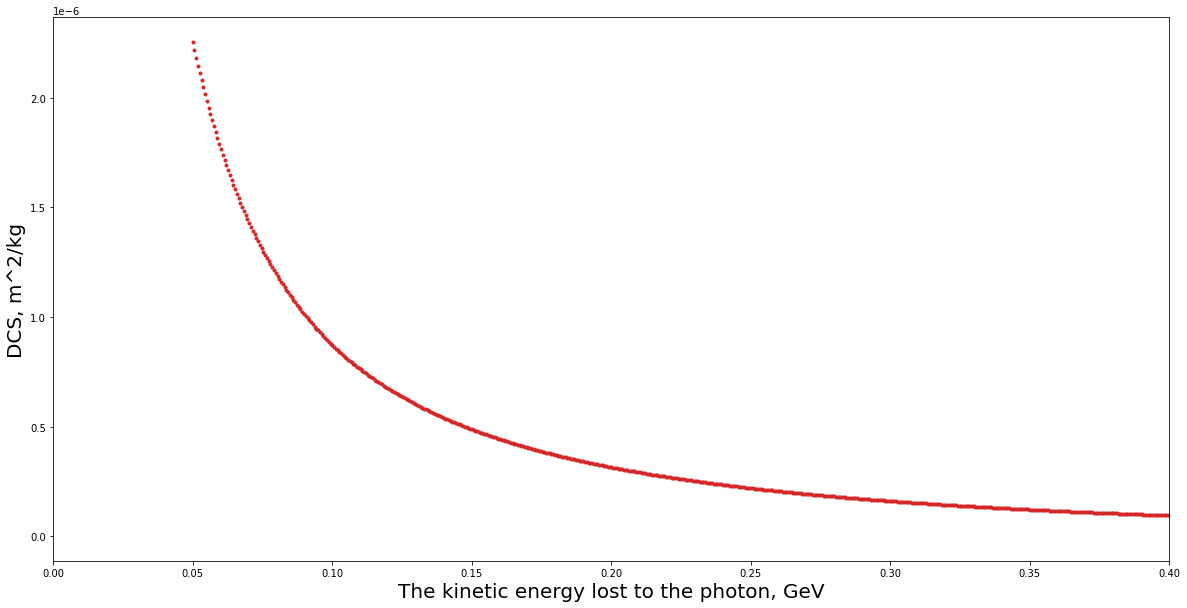

In [22]:
E = 2
sample = 1500
X = []
Y = []
for i in range(sample):
    x = 0.05 + i*(1 - 0.05)/sample;
    y = bremsstrahlung(1, x, 22, 11, 0.10565839)
    X.append(x)
    Y.append(y)
    

fig, ax = plt.subplots()
ax.plot(X, Y, '.C3')    
plt.xlim([0.,0.4])

ax.set_xlabel('The kinetic energy lost to the photon, GeV', fontsize = 20)
ax.set_ylabel('DCS, m^2/kg', fontsize = 20)

fig.set_figwidth(20)
fig.set_figheight(10)
    
plt.show()

In [23]:
brems_numba = bremsstrahlung_numba(
    kinetic_energies,
    recoil_energies,
    STANDARD_ROCK.A,
    STANDARD_ROCK.Z,
    MUON_MASS)
brems_numba[:5]

tensor([3.5293e-04, 3.9395e-06, 4.0777e-06, 4.1341e-06, 4.1650e-06],
       dtype=torch.float64)

In [26]:
%timeit bremsstrahlung_numba(kinetic_energies, recoil_energies, STANDARD_ROCK.A,STANDARD_ROCK.Z,MUON_MASS)

1.03 ms ± 599 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [27]:
%timeit muons.bremsstrahlung_dcs(kinetic_energies, recoil_energies)

346 µs ± 114 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [28]:
%timeit muons_cuda.bremsstrahlung_dcs(kinetic_energies_gpu, recoil_energies_gpu)

162 µs ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Thanks to Slava Kovalev for the numba implementation

### Polynomial model for high energy DCS

An interpolation model in $\tau = q/K$ is used for $K \geq 10$ GeV and $0.05 \leq \tau \leq 0.95$. For Bremsstrahlung we re-write:

\begin{equation}
\frac{K}{E} \frac{\text{d}\sigma}{\text{d}q} = \frac{K \alpha Z}{q}(2\frac{m_e}{m_\mu})^{2}(\frac{4}{3}(1 - \nu) + \nu^2)(\Phi_\text{in}(\delta) + Z\Phi_n(\delta) ) \frac{N_a}{A \cdot 10^{-3}}
\end{equation}

Setting $X=\ln(\tau)$ and $Y=\ln(1-\tau)$, we fit the model:
\begin{equation}
\ln \left( \frac{K}{E} \frac{\text{d}\sigma}{\text{d}q} \right) \approx \sum_{i=0}^{6} a_i X^i + b_1 Y + b_2 Y^2
\end{equation}

### Exercises

**(1)** Implement the Bremsstrahlung formula (taking performance into consideration)

**(2)** Fit the polynomial model for the kinetic energies below. How could you improve it?